오늘은 캐글의 폐렴환자 데이터를 이용하여, 폐렴 여부를 판단하는 프로젝트를 진행해 보았습니다.

데이터 출처 : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

폐렴의 정의는 다음과 같습니다.

> 폐렴(pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다. 세균을 통한 감염이 가장 많으며, 바이러스, 균류, 또는 기타 미생물도 원인이 될 수가 있다. 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 한다. 노인이나 어린아이, 혹은 전체적으로 상태가 안 좋은 환자들이나 기침 반사가 약한 사람들에게는 흡인성 폐렴이 발생한다. 그리고 세균이 원인인 경우는 항생제로 치료를 할 수 있다. 항생제가 생기기 전에는 50~90%가 사망할 정도로 위험한 질환이었으나, 현재는 거의 사망하지 않는다. 1940년대에 항생제가 개발되기 전까지는 폐렴 환자의 1/3 정도가 사망하였다. 오늘날에는 적절한 의학적 치료로 폐렴 환자의 95% 이상이 회복된다. 그러나 일부 저개발국(개발 도상국)에서는 폐렴이 여전히 주요 사망 원인 중 하나이다.

출처 : https://ko.wikipedia.org/wiki/폐렴

폐렴의 구별법은 예상외로 가능합니다. 폐부위에 다양한 양상의 음영이 관찰됩니다. 아래 사진을 보면 이해가 가실 것 입니다.
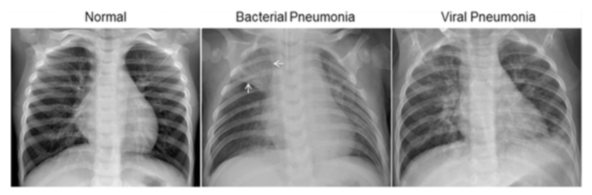

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 학습시킬 데이터 불러오기

In [2]:
# 앞으로 필요한 변수들을 생성합니다.

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)


/aiffel/aiffel


데이터 구조는 다음과 같습니다.

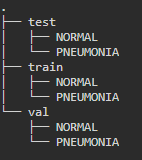

In [3]:
# 파일의 개수를 체크해보았습니다.

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


# train, test, val 데이터 비율 나누기

train : test : val = 89 : 10.7 : 0.3 이므로 train에서 val에 쓰일 데이터를 더 가져와 주었습니다.

train과 val 데이터를 모은 다음, 80 : 20으로 분할하였습니다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


# 정상 환자 사진과 폐렴 환자의 사진 라벨 달기
train 데이터와 validation 데이터의 총 개수는 4185, 1047개이지만, 여기에 정상환자 사진과, 폐렴환자 사진이 어느정도의 비율로 들어가있는지는 알 지 못합니다. 그렇기 때문에 정상과 폐렴환자의 사진 비율을 세어 주었습니다.

### train과 validation set

In [5]:
# 정상 환자 사진과 폐렴환자 사진의 수를 세어보았습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
#이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해보았습니다.
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
print("\n\n")    
    
for image, label in val_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())    

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False



Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True


### test

In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(len(test_ds))

for image, label in test_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())    

id(image)    

39
Image shape:  (16, 180, 180, 3)
Label:  [ True  True  True False False False  True  True False  True False  True
  True  True False False]
Image shape:  (16, 180, 180, 3)
Label:  [ True  True  True  True  True  True  True  True  True  True False  True
 False  True  True False]
Image shape:  (16, 180, 180, 3)
Label:  [ True  True  True False  True  True False  True  True  True False False
 False  True False  True]


140170733708032

# tensorflow pipeline

tf.data 파이프라인을 사용하면 학습 데이터를 효율적으로 사용할 수 있습니다.
이 파이프라인을 이용하여 prepare_for_training() 함수를 정의해보았습니다.

shuffle() 메소드를 사용해 고정 크기 버퍼를 유지하고 그 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 됩니다. 이때 repeat()를 사용한 데이터셋의 경우에는 여러 번 데이터셋을 사용할 수 있게 해줍니다.
- ex ) 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요합니다. repeat()를 사용하면 자동으로 데이터가 맞춰집니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다. 
- ex ) 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어옵니다. 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있습니다. 그렇기 때문에 리소스의 유휴 상태를 줄일 수 있습니다.

In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# show_batch

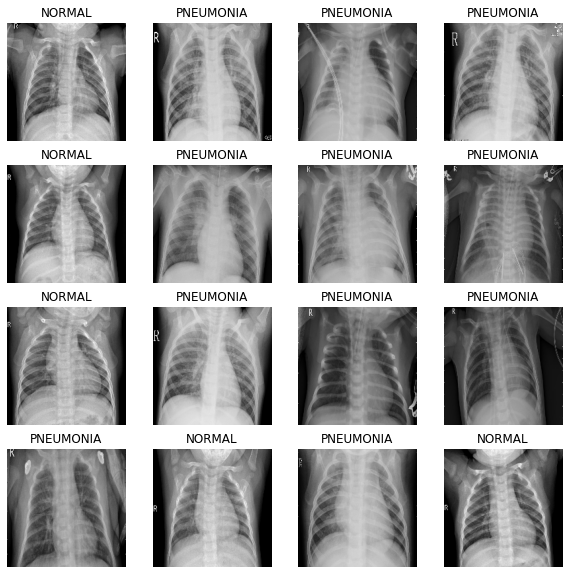

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 폐렴 진단해보기

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense Block은 아래와 같이 만듭니다.

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.25),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 데이터 imbalance 처리

In [16]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# 모델 훈련
이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다. 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [17]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [18]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 61s 189ms/step - loss: 0.3549 - accuracy: 0.8360 - precision: 0.9608 - recall: 0.8127 - val_loss: 0.6685 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2345 - accuracy: 0.9145 - precision: 0.9706 - recall: 0.9128 - val_loss: 1.1316 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1836 - accuracy: 0.9248 - precision: 0.9788 - recall: 0.9189 - val_loss: 0.1135 - val_accuracy: 0.9558 - val_precision: 0.9799 - val_recall: 0.9594
Epoch 4/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1589 - accuracy: 0.9409 - precision: 0.9818 - recall: 0.9380 - val_loss: 0.2465 - val_accuracy: 0.9173 - val_precision: 0.9971 - val_recall: 0.8896
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1325 - accura

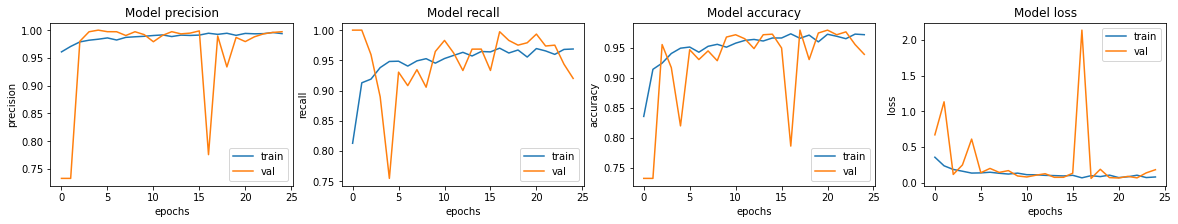

In [19]:
# 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 112ms/step - loss: 0.6552 - accuracy: 0.8718 - precision: 0.8588 - recall: 0.9513
Loss: 0.6551920175552368,
Accuracy: 0.8717948794364929,
Precision: 0.8587962985038757,
Recall: 0.9512820243835449


# 성능 개선

# step 1. 실험환경 Set-
batch size와 epoch를 20,30으로 변경했습니다.

In [21]:


train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

BATCH_SIZE = 20
EPOCHS = 30


In [ ]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


# step 2. 데이터 준비하기

노드에는 flip된 이미지를 사용해 보라고 하였지만, 해당 데이터는 flip되면 안된다고 생각했습니다. 환자의 오른쪽 왼쪽이 바뀔 뿐더러, 의사들이 xray를 뒤집어서 보는 경우는 없다고 알고있습니다. 
그리고 심장은 중간에서 왼쪽으로 약간 치우쳐져있습니다. 그런데 이것을 flip해버리게 되면 심장의 위치가 반대가 되어버리기에 오히려 노이즈가 더 커진다고 생각했습니다.
그래서 환자가 움직임을 대비하여 rotate된 이미지만 추가해 주어야 한다고 생각해 roate된 이미지만 augmentation으로 추가하였습니다.

실제로 flip과 rotate를 같이사용한 경우보다 rotate만 사용한 경우가 accuracy가 더 높았습니다.

Rotate된 이미지 추가
https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko

In [22]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.03),
])

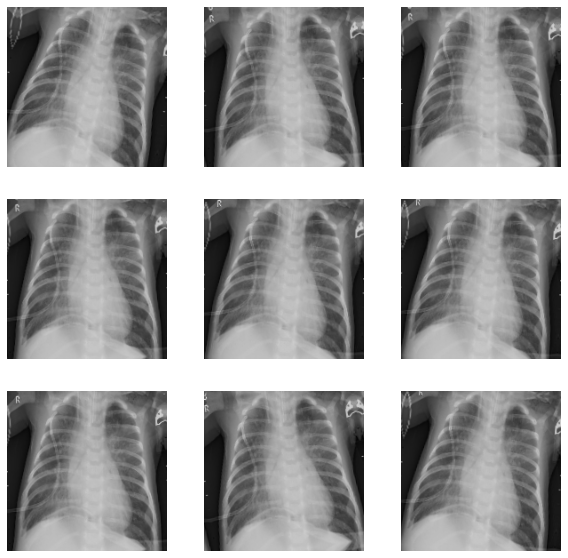

In [23]:
# rotate 코드가 제대로 동작하는시 확인해 보았습니다.

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### 모델에 random rotate 층 추가

In [24]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
#         layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.03),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [25]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
209/209 [==============================] - 50s 200ms/step - loss: 0.4648 - accuracy: 0.7658 - precision: 0.9376 - recall: 0.7350 - val_loss: 0.6089 - val_accuracy: 0.7284 - val_precision: 0.7284 - val_recall: 1.0000
Epoch 2/30
209/209 [==============================] - 41s 197ms/step - loss: 0.2447 - accuracy: 0.9010 - precision: 0.9724 - recall: 0.8921 - val_loss: 1.1940 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/30
209/209 [==============================] - 41s 196ms/step - loss: 0.2142 - accuracy: 0.9154 - precision: 0.9790 - recall: 0.9070 - val_loss: 1.2414 - val_accuracy: 0.7380 - val_precision: 0.7380 - val_recall: 1.0000
Epoch 4/30
209/209 [==============================] - 41s 197ms/step - loss: 0.2139 - accuracy: 0.9225 - precision: 0.9700 - recall: 0.9230 - val_loss: 0.1272 - val_accuracy: 0.9531 - val_precision: 0.9817 - val_recall: 0.9548
Epoch 5/30
209/209 [==============================] - 42s 204ms/step - loss: 0.1778 - accura

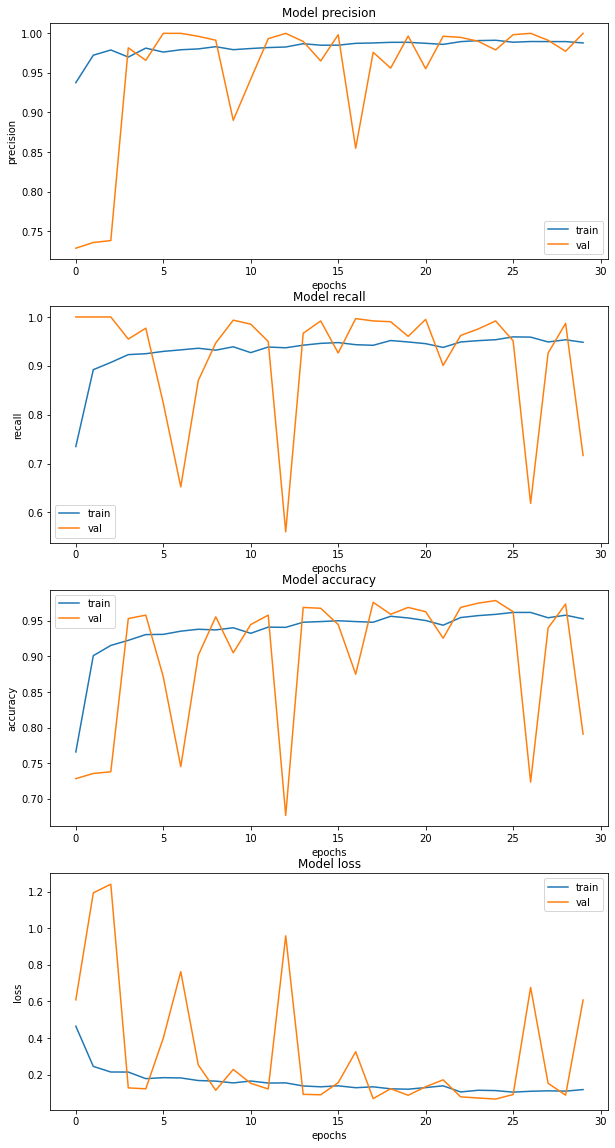

In [27]:
# 결과 확인
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.4899 - accuracy: 0.8333 - precision: 0.8994 - recall: 0.8256
Loss: 0.4898660182952881,
Accuracy: 0.8333333134651184,
Precision: 0.8994413614273071,
Recall: 0.8256410360336304


In [29]:
print(type(model))

<class 'keras.engine.sequential.Sequential'>


# step 4. CNN 모델링

dense층에서는 batchnormalization과 dropout층을 둘다사용해보기도하고, 하나씩만사용해보기도했는데, batchnormaliation층만 있었을 때가 성능이 가장 나아서 dropout층에서는 제외시켜주었습니다.

또한 maxpool링층에 필터를 넣어주고, 마지막 dense층에 dropout층을추가하는등의시도를 해보았습니다.

In [30]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2))
    ])
    
    return block

# Dense Block은 아래와 같이 만듭니다.

def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        layers.experimental.preprocessing.RandomRotation(0.03),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.25),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Flatten(),
        dense_block(512),
        dense_block(128),
        dense_block(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# step 5. 데이터 불균형처리

캐글 스터디에서 stratifiedKFold라는 기법을 알게되었습니다. 불균형한 dataset일 경우 사용하는 kfold 방법으로, k개의 fold를 분할한 이후에도 전체 훈련 데이터의 class 비율과 각 fold가 가지고 있는 class 비율을 맞춰주는 것입니다
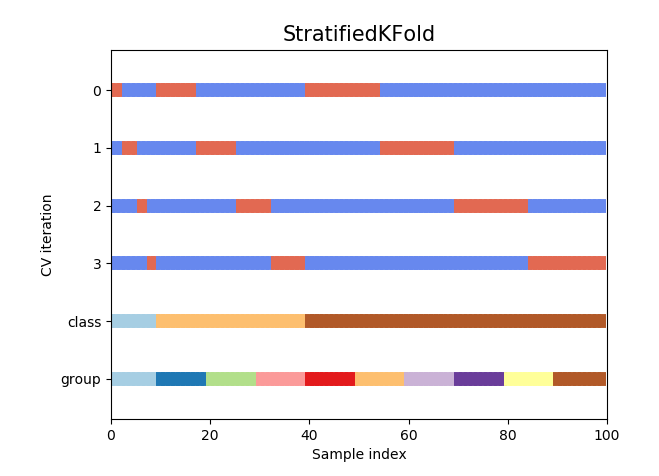


이 기법은 최종적으로 실패했지만 다음에 꼭 성공시키고 싶습니다. 다음은 시도한 노력입니다ㅠ_ㅠ

https://steadiness-193.tistory.com/287
https://guru.tistory.com/35

### 기존의 tensorflow 데이터 형식을 유지하여 stratified KFold 시도

In [31]:
len(filenames)

5232

In [32]:
COUNT_NORMAL = len([filename for filename in filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [33]:
train_and_val_list_ds = tf.data.Dataset.from_tensor_slices(filenames)


In [34]:
TRAIN_VAL_IMG_COUNT = tf.data.experimental.cardinality(train_and_val_list_ds).numpy()
print(f"Training images count: {TRAIN_VAL_IMG_COUNT}")

Training images count: 5232


In [35]:
train_val_ds = train_and_val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [36]:
for image, label in train_val_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False


In [37]:
print(type(train_val_ds))
print(train_val_ds)
print(len(train_val_ds))

<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>
5232


In [38]:
for image, label in train_val_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
print("\n\n")   
    
for image, label in train_val_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())    

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  False



Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  False


In [39]:
# train_val_ds = prepare_for_training(train_val_ds)

In [40]:
# # all_images_true = np.empty(shape=(180,180,3))
# # all_images_false = np.empty(shape=(180,180,3))
# # all_targets_true = np.empty(shape=1)
# # all_targets_false = np.empty(shape=1)


# len(train_val_ds)

# # for image, label in train_val_ds.take(len(train_val_ds)):
# #     if label.numpy():
# #         all_images_true.append(image.numpy())
# #         all_targets_true.append(label.numpy())
# #     else:
# #         all_images_false.append(image.numpy())
# #         all_targets_false.append(label.numpy())
    
# # print(len(all_images_false), len(all_images_true))    

# for image, label in train_val_ds.take(len(train_val_ds)):
#     if label.numpy():
#         all_images_true.append(image.numpy())
#         all_targets_true.append(label.numpy())
#     else:
#         all_images_false.append(image.numpy())
#         all_targets_false.append(label.numpy())

### pandas dataframe으로 데이터를 만들어주어 stratifiedKFold시도

In [41]:

label=[True,True,False,True,False]
print(label)
label.sort()
print(label)


[True, True, False, True, False]
[False, False, True, True, True]


In [42]:
img_true=[]
target_true=[]
img_false=[]
target_false=[]

def prepare_stratifiedKfold(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    
    if label:
        target_true.append(label)
        img_true.append(img)
    else:
        target_false.append(label)
        img_false.append(img)
        

In [43]:
len(filenames)

5232

In [44]:
for f in filenames:
    prepare_stratifiedKfold(f)
    

In [45]:
print(len(img_true), len( img_false))

3883 1349


In [46]:
all_img = img_false + img_true
print(len(all_img))
all_label = target_false + target_true
print(len(all_label))


5232
5232


In [47]:
# from sklearn.model_selection import StratifiedKFold
# import pandas as pd

# skf = StratifiedKFold(n_splits=5, shuffle=True)

# df_all_img = pd.DataFrame(all_img)
# df_all_label = pd.DataFrame(all_label)


# for i, (train_index, val_index) in enumerate(skf.split(df_all_img, df_all_label)):
#     x_train, y_train = df_all_img.iloc[train_index, :], df_all_label[train_index,]
#     x_valid, y_valid = df_all_img.iloc[val_index, :], df_all_label[val_index,]

In [48]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.55
Weight for PNEUMONIA: 0.54


# step 6, 7 모델 훈련 및 결과 확인과 시각화

In [49]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [50]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
209/209 [==============================] - 50s 198ms/step - loss: 0.2517 - accuracy: 0.8556 - precision: 0.9624 - recall: 0.8375 - val_loss: 0.5963 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/30
209/209 [==============================] - 41s 196ms/step - loss: 0.1640 - accuracy: 0.9243 - precision: 0.9777 - recall: 0.9206 - val_loss: 1.1158 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/30
209/209 [==============================] - 41s 195ms/step - loss: 0.1498 - accuracy: 0.9300 - precision: 0.9776 - recall: 0.9273 - val_loss: 0.9578 - val_accuracy: 0.7284 - val_precision: 0.7284 - val_recall: 1.0000
Epoch 4/30
209/209 [==============================] - 42s 200ms/step - loss: 0.1334 - accuracy: 0.9309 - precision: 0.9770 - recall: 0.9284 - val_loss: 0.3469 - val_accuracy: 0.8425 - val_precision: 0.8238 - val_recall: 0.9984
Epoch 5/30
209/209 [==============================] - 43s 205ms/step - loss: 0.1271 - accura

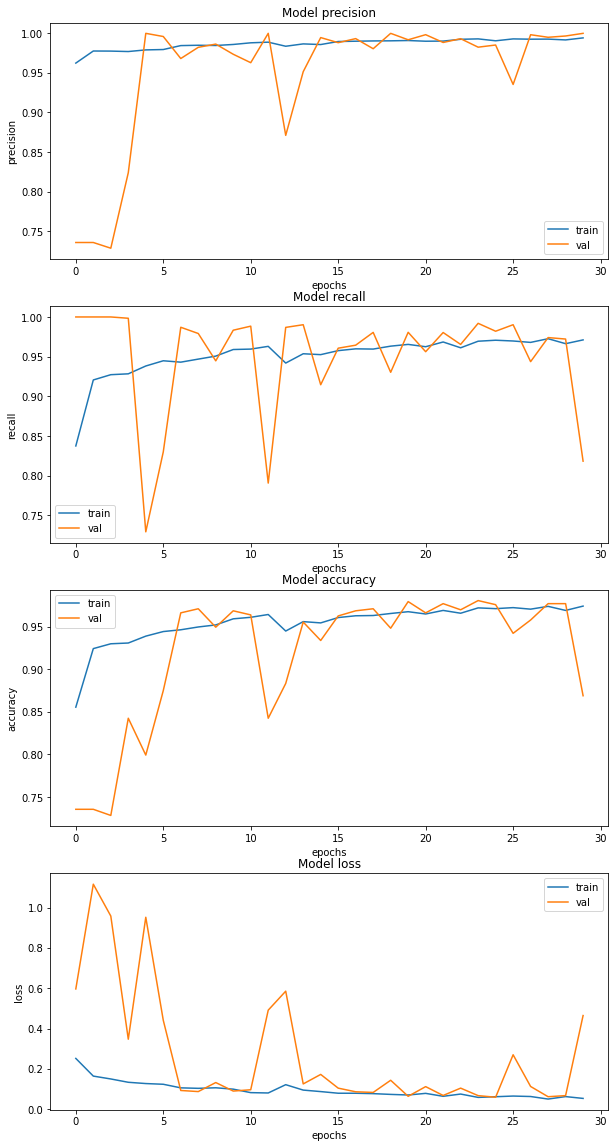

In [51]:
# 결과 확인
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [52]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.6043 - accuracy: 0.8462 - precision: 0.8657 - recall: 0.8923
Loss: 0.6043486595153809,
Accuracy: 0.8461538553237915,
Precision: 0.8656716346740723,
Recall: 0.892307698726654


회고

- image rotate

정말 간단한 기능이지만, 생각보다 많이 헤맸습니다. 방법도 너무 많았고 어느 단계에서 해주느냐에 따라서도 방법이 나뉘었기 때문입니다.
이미지를 돌리는 방법은 PIL 에서 image.rotate해주는 방법, tensorflow 버전 1에서만 돌아가는 rotation방법, 혹은 cv2.image로 데이터를 할당해서 rotate해주는 방법, tensor 상태에서 image를 돌리는법.. 모델층안에서 데이터 돌리는 법 등 정말 많았습니다.
처음에는 먼저 이미지를 돌리고 tensor에 추가하려했다가, tensorflow자체에 rotate 메소드가 있을 것 같아 또 한참 찾아 시도하고 하다보니 나열한 방법 대부분을 건드려보면서 시간이 많이 지체된 것이 아쉽습니다.
실패했을 때도 있고, 데이터 형변환을 했다가 돌려주고 왔다갔다하는 지저분한 코드때문에 계속 새로운 방법을 강구하다보니 그렇게 되었습니다. 

이런 경험이 많이 쌓여 언젠간 간단한 기능은 간단하게 뚝딱 해낼 수 있으면 좋겠습니다.

- Stratified K Fold

캐글스터디에서 알게 된 새 기법이었습니다. KFold에서 발전된 방법으로 각 split된 그룹마다 정상데이터와 폐렴데이터를 균일하게 맞추어주는 방법이기 때문에 학습이 안정적으로 이루어집니다.아래 사진을 보면, 에포크가 쌓일 때마다 loss가 안정적으로 낮춰지다가 어떤 에포크에 갑자기 튀는 경우가 있었습니다. 아마 stratifiedkfold를 이용했으면 그런 경우가 줄어들었을거란 생각이듭니다.
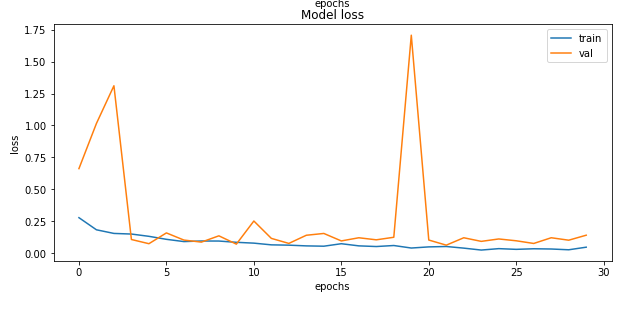

- 전체 회고

오늘의 익스 노드는 제 부족한 점과 공부를 해야할 방향이 잘 보여주었습니다. 이제껏 노드를 진행하고 스터디를 하면서 AI 모델의 개선방법을 많이 알게되고 패키지를 많이 알게되었습니다. 하지만 이를 적용하기에는 아직 실력이 부족하며, 같은 기능이라도 패키지나 어떤 툴을 사용하는지에 따라 메소드가 천차만별입니다. sklearn의 기능을 tensorflow에 접목할 수있는지, tensor 데이터형을 numpy로 나눌 수 있는지, 패키지간의 상호작용을 알고싶고, 패키지 자체의 기능도 더 자세히 알고싶습니다. 그리고 어떤 패키지에 국한되지 않고 sklearn에있는 기능을 코드를 통해 tensorflow형 데이터 메소드들에서도 사용할 수 있도록 코드를 작성하는 능력을 키우고 싶습니다.

원하는 개선 사항
- sklearn에서 grid search를 했던 경험이 있습니다. step1에서 하이퍼 파라미터를 sklearn의 grid search 모델과 결합시켜 tensorflow에서 돌려보고싶습니다.
- StratifiedKFold의 시도는 sklearn에는 pandas Dataframe이 보통 들어가는데 여기선 tensorflow Paralle dataset?과 같은 형식이라 이를 변환하려 여러 시도를 해보았었습니다. 시간제한상 이 기능은 완성하지 못했지만, tensorflow 데이터 형식에도 가능한지도 알아내고 싶고 이 기능을 마무리 해내고싶습니다.
- 캐글 스터디에서 어떤 주제에서 1등한 분은 pretrained 된 모델을 가져와 데이터와 결부시켰었습니다. timm이라는 패키지를 사용하시던데, lms에서는 설치된 상태는 아니었습니다. 다음에는 timm 패키지를 설치하고 거기서 pretrained 된 모델을 가져와 학습에 이용해보고싶습니다.